In [65]:
#im using CPU hehe
import torch

if torch.cuda.is_available():
  device = torch.device('cuda')

  print('there are %d GPU(s) available.' % torch.cuda.device_count())

  print('we will use the GPU: ', torch.cuda.get_device_name(0))

else:
  print("No GPU available, using the CPU instead")
  device = torch.device("cpu")

No GPU available, using the CPU instead


In [66]:
#do pip install transformers if haven't
!pip install transformers

You should consider upgrading via the 'C:\Users\tiffa\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [67]:
import pandas as pd

df = pd.read_csv("./GenshinReview.csv")
df.shape

(4200, 2)

In [68]:
df.sample(100)

,score,content
914,2,no doubt the game is best but also boring and ...
288,1,the luck system is bullshit even when you spen...
430,1,update like you asked i would not give it one ...
1366,3,great game with new concepts and event upgradi...
2418,3,really fun and cool game love it but it gets r...
...,...,...
3491,5,despite the high demand of storage its fifty g...
3323,5,more places to teleport from all places becaus...
2898,4,i have encountered a bug so when i log in to m...
137,1,i had not played the game for a few months and...


In [70]:
#creating label called sentiment from the score reviews
#1-2: negative
#3: neutral
#4-5: positive

def map_rating_to_sentiment(rating):
    if rating in [1, 2]:
        return 0
    elif rating == 3:
        return 1
    elif rating in [4, 5]:
        return 2

df['sentiment'] = df['score'].apply(map_rating_to_sentiment)

df.head(3000)

,score,content,sentiment
0,1,for whatever reason my game used to work just ...,0
1,1,i do like this game but there is seriously thi...,0
2,1,downloaded it once and it worked downloaded it...,0
3,1,my data is mbps when i open this game the ms s...,0
4,1,i have not played the game because of some pro...,0
...,...,...,...
2995,4,great game with no end content and a very expe...,2
2996,4,a very good game with beautiful graphic and ni...,2
2997,4,good game with there was better camera control...,2
2998,4,surprisingly high quality for a mobile game li...,2


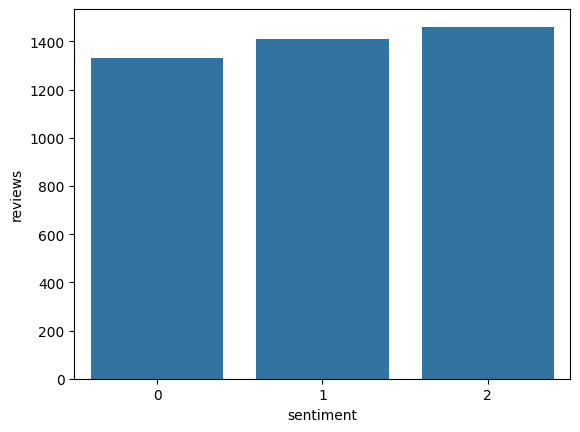

In [71]:
import seaborn as sns
import matplotlib.pyplot as plt

#for now we have 2000 rows of reviews. we'll add more data perhaps later if the accuracy is still bad.
x = df.sentiment.value_counts()
sns.barplot(x=x.index, y=x)
plt.gca().set_ylabel('reviews')
plt.show()

In [72]:
sentences = df.content.values
labels = df.sentiment.values

In [73]:
from transformers import BertTokenizer
#using pretrained bert tokenizer
print("Loading BERT Tokenizer")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT Tokenizer


In [74]:
print("Original: ", sentences[0])
#yes it's not perfect, game word terms like primogems are not identified as english word.
print("Tokenized: ", tokenizer.tokenize(sentences[0]))
#tokenization time
print("Token IDS: ", tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

Original:  for whatever reason my game used to work just fine except for cutscenes when it crashed and would not play so i had to use geforce but now it just refuses to open it opens up shows a black screen and promptly crashes again i have tried uninstalling and reinstalling took about three hour by the way and restarting my device it just does not work fun game though
Tokenized:  ['for', 'whatever', 'reason', 'my', 'game', 'used', 'to', 'work', 'just', 'fine', 'except', 'for', 'cuts', '##cene', '##s', 'when', 'it', 'crashed', 'and', 'would', 'not', 'play', 'so', 'i', 'had', 'to', 'use', 'ge', '##force', 'but', 'now', 'it', 'just', 'refuses', 'to', 'open', 'it', 'opens', 'up', 'shows', 'a', 'black', 'screen', 'and', 'promptly', 'crashes', 'again', 'i', 'have', 'tried', 'un', '##ins', '##tal', '##ling', 'and', 'reins', '##tal', '##ling', 'took', 'about', 'three', 'hour', 'by', 'the', 'way', 'and', 'restart', '##ing', 'my', 'device', 'it', 'just', 'does', 'not', 'work', 'fun', 'game', '

In [75]:
input_ids = []

for sent in sentences:
    # Check for NaN values and empty strings
    if pd.notna(sent) and sent != "":
        encoded_sent = tokenizer.encode(
            sent,
            add_special_tokens=True
        )
        input_ids.append(encoded_sent)

print("Original: ", sentences[0])
print("Token IDs: ", input_ids[0])


Token indices sequence length is longer than the specified maximum sequence length for this model (812 > 512). Running this sequence through the model will result in indexing errors


Original:  for whatever reason my game used to work just fine except for cutscenes when it crashed and would not play so i had to use geforce but now it just refuses to open it opens up shows a black screen and promptly crashes again i have tried uninstalling and reinstalling took about three hour by the way and restarting my device it just does not work fun game though
Token IDs:  [101, 2005, 3649, 3114, 2026, 2208, 2109, 2000, 2147, 2074, 2986, 3272, 2005, 7659, 17968, 2015, 2043, 2009, 8007, 1998, 2052, 2025, 2377, 2061, 1045, 2018, 2000, 2224, 16216, 14821, 2021, 2085, 2009, 2074, 10220, 2000, 2330, 2009, 7480, 2039, 3065, 1037, 2304, 3898, 1998, 13364, 19119, 2153, 1045, 2031, 2699, 4895, 7076, 9080, 2989, 1998, 19222, 9080, 2989, 2165, 2055, 2093, 3178, 2011, 1996, 2126, 1998, 23818, 2075, 2026, 5080, 2009, 2074, 2515, 2025, 2147, 4569, 2208, 2295, 102]


In [76]:
print("Max sentence length: ", max([len(sen) for sen in input_ids]))

Max sentence length:  812


In [77]:
from keras.preprocessing.sequence import pad_sequences

MAX_LEN = 64

print("Padding/truncating all sentences to %d values" % MAX_LEN)
print('Padding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype='long', value=0, truncating='post', padding='post')

print("Done")

Padding/truncating all sentences to 64 values
Padding token: "[PAD]", ID: 0
Done


In [78]:
input_ids[0]

array([  101,  2005,  3649,  3114,  2026,  2208,  2109,  2000,  2147,
        2074,  2986,  3272,  2005,  7659, 17968,  2015,  2043,  2009,
        8007,  1998,  2052,  2025,  2377,  2061,  1045,  2018,  2000,
        2224, 16216, 14821,  2021,  2085,  2009,  2074, 10220,  2000,
        2330,  2009,  7480,  2039,  3065,  1037,  2304,  3898,  1998,
       13364, 19119,  2153,  1045,  2031,  2699,  4895,  7076,  9080,
        2989,  1998, 19222,  9080,  2989,  2165,  2055,  2093,  3178,
        2011])

In [79]:
attention_mask = []

for sent in input_ids:
  att_mask = [int(token_id > 0) for token_id in sent]

  attention_mask.append(att_mask)

In [80]:
from sklearn.model_selection import train_test_split

train_input, test_input, train_labels, test_labels = train_test_split(input_ids,labels, random_state=42, test_size=0.1)
train_mask, test_mask, _, _ = train_test_split(attention_mask, labels, random_state=42, test_size=0.1)

train_input, validation_input, train_labels, validation_labels = train_test_split(train_input, train_labels, random_state= 43, test_size=0.15)
train_mask, validation_mask, _, _ = train_test_split(train_mask, train_mask, random_state=43, test_size=0.15)

In [81]:
import numpy as np
print("== Train ==")
print("Input: ", train_input.shape)
print("Label: ", train_labels.shape)
print("Mask: ", np.array(train_mask).shape)

print("\n== Validation ==")
print("Input: ", validation_input.shape)
print("Label: ", validation_labels.shape)
print("Mask: ", np.array(validation_mask).shape)

print("\n== Test ==")
print("Input: ", test_input.shape)
print("Label: ", test_labels.shape)
print("Mask: ", np.array(test_mask).shape)

== Train ==
Input:  (3213, 64)
Label:  (3213,)
Mask:  (3213, 64)

== Validation ==
Input:  (567, 64)
Label:  (567,)
Mask:  (567, 64)

== Test ==
Input:  (420, 64)
Label:  (420,)
Mask:  (420, 64)


In [82]:
train_input = torch.tensor(train_input)
train_labels = torch.tensor(train_labels)
train_mask = torch.tensor(train_mask)

validation_input = torch.tensor(validation_input)
validation_labels = torch.tensor(validation_labels)
validation_mask = torch.tensor(validation_mask)

test_input = torch.tensor(test_input)
test_labels = torch.tensor(test_labels)
test_mask = torch.tensor(test_mask)

In [83]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 32

train_data = TensorDataset(train_input, train_mask, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_input, validation_mask, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

test_data = TensorDataset(test_input, test_mask, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [84]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels = 3,
    output_attentions = False,
    output_hidden_states = False
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [85]:
params = list(model.named_parameters())

print("The BERT model has {:} different named parameters.".format(len(params)))

print("==== Embedding Layer ====")
for p in params[0:5]:
  print("{:<60} {:>12}".format(p[0], str(tuple(p[1].size()))))

print("==== First Transformers ====")
for p in params[5:21]:
  print("{:<60} {:>12}".format(p[0], str(tuple(p[1].size()))))

print("==== Output Layer ====")
for p in params[-4:]:
  print("{:<60} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.
==== Embedding Layer ====
bert.embeddings.word_embeddings.weight                       (30522, 768)
bert.embeddings.position_embeddings.weight                     (512, 768)
bert.embeddings.token_type_embeddings.weight                     (2, 768)
bert.embeddings.LayerNorm.weight                                   (768,)
bert.embeddings.LayerNorm.bias                                     (768,)
==== First Transformers ====
bert.encoder.layer.0.attention.self.query.weight               (768, 768)
bert.encoder.layer.0.attention.self.query.bias                     (768,)
bert.encoder.layer.0.attention.self.key.weight                 (768, 768)
bert.encoder.layer.0.attention.self.key.bias                       (768,)
bert.encoder.layer.0.attention.self.value.weight               (768, 768)
bert.encoder.layer.0.attention.self.value.bias                     (768,)
bert.encoder.layer.0.attention.output.dense.weight             (768, 768)
bert.e

In [86]:
optimizer = AdamW(
    model.parameters(),
    lr = 2e-5,
    eps = 1e-8
)

C:\Users\tiffa\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [87]:
from transformers import get_linear_schedule_with_warmup

epochs = 10

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

In [88]:
import numpy as np

def flat_accuracy(preds, labels):
  pred_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()
  return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [89]:
import time
import datetime

def format_time(elapsed):
  elapsed_rounded = int(round(elapsed))
  return str(datetime.timedelta(seconds=elapsed_rounded))

In [90]:
import random
#to make sure it's the same
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)

loss_values = []

for epoch_i in range(0, epochs):

#Training time
  print("======= Epoch {:} / {:} =======".format(epoch_i+1, epochs))
  print("Training...")

  t0 = time.time()

  total_loss = 0
#only to prepare the model in a state of where it's ready for training
  model.train()

  #for each batch of training data
  for step, batch in enumerate(train_dataloader):
    
    #progress update every 10 batches
    if step % 40 == 0 and not step == 0:
      elapsed = format_time(time.time() - t0)

      print("Batch {:>5,} of {:>5,}.     Elapsed: {:}".format(step, len(train_dataloader), elapsed))
    
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    model.zero_grad()

    outputs = model(b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_input_mask,
                    labels=b_labels)
    
    loss = outputs[0]
    total_loss += loss.item()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    scheduler.step()

  avg_train_loss = total_loss / len(train_dataloader)
  loss_values.append(avg_train_loss)

  print("   Average training loss: {0:.2f}".format(avg_train_loss))
  print("   Training epoch took: {:}".format(format_time(time.time() - t0)))

#validation time
  print("Running Validation...")
  t0 = time.time()
  model.eval()
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  for batch in validation_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():
      outputs = model(b_input_ids,
                      token_type_ids=None,
                      attention_mask=b_input_mask)
    
    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1
  
  print("   Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
  print("   Validation took: {:}".format(format_time(time.time() - t0)))

print("Training complete!")

======= Epoch 1 / 10 =======
Training...
Batch    40 of   101.     Elapsed: 0:15:42
Batch    80 of   101.     Elapsed: 0:26:56
   Average training loss: 0.96
   Training epoch took: 0:31:40
Running Validation...
   Accuracy: 0.59
   Validation took: 0:01:21
======= Epoch 2 / 10 =======
Training...
Batch    40 of   101.     Elapsed: 0:09:17
Batch    80 of   101.     Elapsed: 0:18:37
   Average training loss: 0.76
   Training epoch took: 0:23:23
Running Validation...
   Accuracy: 0.57
   Validation took: 0:01:19
======= Epoch 3 / 10 =======
Training...
Batch    40 of   101.     Elapsed: 0:09:17
Batch    80 of   101.     Elapsed: 0:18:38
   Average training loss: 0.60
   Training epoch took: 0:23:22
Running Validation...
   Accuracy: 0.57
   Validation took: 0:01:22
======= Epoch 4 / 10 =======
Training...
Batch    40 of   101.     Elapsed: 0:09:17
Batch    80 of   101.     Elapsed: 0:18:33
   Average training loss: 0.47
   Training epoch took: 0:23:16
Running Validation...
   Accuracy: 0

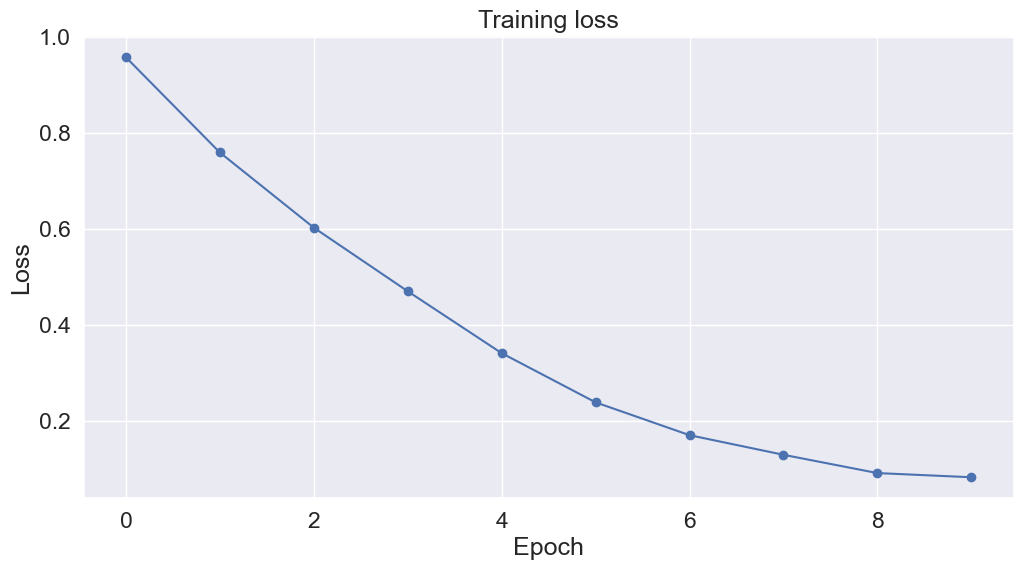

In [99]:
%matplotlib inline
import matplotlib.pyplot as plt


#plotting will be continued once this thing is done training bro
import seaborn as sns

sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(loss_values, 'b-o')

plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

In [97]:
print("Predicting labels for {:,} test sentences".format(len(test_input)))

model.eval()

prediction, true_labels = [], []

for batch in test_dataloader:
  batch = tuple(t.to(device) for t in batch)

  b_input_ids, b_input_mask, b_labels = batch

  with torch.no_grad():
    outputs = model(b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_input_mask)
    
  logits = outputs[0]

  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  prediction.append(logits)
  true_labels.append(label_ids)

print("finally??? done!!!!")

Predicting labels for 420 test sentences
finally??? done!!!!


In [100]:
import numpy as np
import pandas as pd

# Assuming prediction and true_labels are lists

# Convert lists to NumPy arrays
prediction_array = np.concatenate(prediction, axis=0)
true_labels_array = np.concatenate(true_labels, axis=0)

# Create a DataFrame
df = pd.DataFrame({
    'Predicted_Labels': np.argmax(prediction_array, axis=1), 
    'True_Labels': true_labels_array
})

# Display the DataFrame
print(df)

     Predicted_Labels  True_Labels
0                   1            1
1                   1            1
2                   1            1
3                   2            2
4                   0            0
..                ...          ...
415                 2            2
416                 1            0
417                 0            0
418                 1            2
419                 2            2

[420 rows x 2 columns]


In [101]:
from sklearn.metrics import matthews_corrcoef, accuracy_score, precision_score, recall_score, f1_score


#convert lists to NumPy arrays
flat_prediction = np.concatenate(prediction, axis=0)
flat_true_labels = np.concatenate(true_labels, axis=0)

#calculate Matthews Correlation Coefficient
mcc = matthews_corrcoef(flat_true_labels, np.argmax(flat_prediction, axis=1))

print("MATTHEWS_CC: %.3f" % mcc)

#calculate Accuracy
acc = accuracy_score(flat_true_labels, np.argmax(flat_prediction, axis=1))

print("ACCURACY: %.3f" % acc)

#calculate Precision
precision = precision_score(flat_true_labels, np.argmax(flat_prediction, axis=1), average='weighted')

print("PRECISION: %.3f" % precision)

#calculate Recall
recall = recall_score(flat_true_labels, np.argmax(flat_prediction, axis=1), average='weighted')

print("RECALL: %.3f" % recall)

#calculate F1-Score
f1 = f1_score(flat_true_labels, np.argmax(flat_prediction, axis=1), average='weighted')

print("F1 SCORE: %.3f" % f1)

MATTHEWS_CC: 0.414
ACCURACY: 0.605
PRECISION: 0.624
RECALL: 0.605
F1 SCORE: 0.602


In [105]:
import pandas as pd
from sklearn.metrics import accuracy_score

#add a column to df indicating whether the prediction is correct
df['Correct_Prediction'] = df['True_Labels'] == df['Predicted_Labels']

#calculate accuracy
accuracy = accuracy_score(df['True_Labels'], df['Predicted_Labels'])
print("Overall Accuracy: {:.2%}".format(accuracy))

#amount of correct predictions for each sentiment class
for sentiment_class in [0, 1, 2]:  #0 for negative, 1 for neutral, 2 for positive
    correct_predictions = df[df['Correct_Prediction'] & (df['True_Labels'] == sentiment_class)].shape[0]
    total_samples = df[df['True_Labels'] == sentiment_class].shape[0]
    print("Correct {} predictions: {}/{}".format(sentiment_class, correct_predictions, total_samples))

Overall Accuracy: 60.48%
Correct 0 predictions: 66/144
Correct 1 predictions: 89/149
Correct 2 predictions: 99/127


In [106]:
df.head(10)

,Predicted_Labels,True_Labels,Correct_Prediction
0,1,1,True
1,1,1,True
2,1,1,True
3,2,2,True
4,0,0,True
5,1,1,True
6,2,2,True
7,0,0,True
8,2,2,True
9,1,1,True


In [107]:
#drop the 'Correct_Prediction' column if not needed
df = df.drop(columns=['Correct_Prediction'])
df.head(10)

,Predicted_Labels,True_Labels
0,1,1
1,1,1
2,1,1
3,2,2
4,0,0
5,1,1
6,2,2
7,0,0
8,2,2
9,1,1
